# RPZ Assignment: Bayesian Decision Making

**Detailed BRUTE upload instructions at the end of this notebook.**

## Introduction

<img src="assets/letter_matrix.png" width="500">

In this lab we will implement an [OCR system](https://en.wikipedia.org/wiki/Optical_character_recognition). For simplicity we assume the texts contain only two letters, A and C, and that the letters are already well segmented into 10x10 pixel image chips. We also assume, that the relative frequency of occurrence of A and C in the text is given. We will extract a simple feature from each image chip and use it in a Bayesian decision framework to partition the image set into A's and C's. We will consider two cases: (1) the measurements are discrete, and (2) the measurements are continuous.

In the **discrete probabilities** case, we will find the optimal strategy, compute its Bayesian risk, experiment with the loss function and classify independent data samples by applying the theory from the lecture slides directly.

In the **continuous measurements** case, an assumption is made that the extracted feature for each letter class (A, C) is generated by a normal distribution. The 'zero-one' loss will be used to estimate risk, which simplifies the decision strategy.


In [35]:
%load_ext autoreload
%autoreload 2

from bayes import *
import scipy.io
import numpy as np
import numpy.testing as testing
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data

We will use the following data in both the discrete and continuous cases.

In [36]:
data = np.load("data_33rpz_bayes.npz", allow_pickle=True)
alphabet = data["alphabet"]
images_test = data["images_test"]
labels_test = data["labels_test"]

The above snippet loads the data in the following variables:

| variable            | description                                                                                             |
|---------------------|---------------------------------------------------------------------------------------------------------|
| `images_test`       | (10, 10, 40) array of **test** gray-scale images of size 10x10 pixels, depicting letters A and C                   |
| `labels_test`       | (40, ) array with ground-truth classification (0=A, 1=C)                                                |

## Part 1: Discrete measurements

The task is to design a classifier (a Bayesian strategy) $q(x)$, which distinguishes between images of two letters (classes), A and C, using only a single measurement (feature):

$$ q: \mathcal{X} \rightarrow D $$
$$ \mathcal{X} = \{-10, \ldots, 10\}, \quad D = K = \{A, C\}$$

The measurement $x$ is obtained from an image by computing

```
mu = -563.9
sigma = 2001.6
x_unnormalized = (sum of pixel values in the left half of image)
                -(sum of pixel values in the right half of image)
x_norm = (x_unnormalized - mu) / (2 * sigma) * 10
x = x_norm limited to the interval <-10, 10> and discretized
```
Notice, that the normalization squeezes most of the $x$ values in the interval $\langle -10, 10 \rangle$.

Computation of this measurement is implemented in `compute_measurement_lr_discrete` function in the `bayes.py` file.

The strategy $q(x)$ will be represented in NumPy by a (21, ) vector containing 0 if the classification for that value of $x$ is supposed to be A, and 1 if the classification is supposed to be C. Thus given the strategy vector $q$ and some $x$ we can decide for one of the classes.



### The distributions

Let us first define the required discrete distributions.

In [37]:

discreteA = {'Prior': 0.6153846153846154,
             'Prob': np.array([0.0125, 0., 0., 0.0125, 0.025, 0.0125, 0.025, 0.0375, 0.075, 0.1, 0.2125, 0.1375, 0.15, 0.1, 0.0875, 0.0125, 0., 0., 0., 0., 0.])}
discreteC = {'Prior': 0.38461538461538464,
             'Prob': np.array([0., 0., 0., 0.02, 0.02, 0.22, 0.46, 0.16, 0.1, 0.02, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}


The above snippet creates the following distribution variables required in the formulation of the Bayesian task:

| variable            | description                                                                                             |
|---------------------|---------------------------------------------------------------------------------------------------------|
| `discreteA['Prob']` | $p_{X\vert k}(x\vert A)$ given as a (21, ) array; the size corresponds to the range of the values of $x$   |
| `discreteA['Prior']` | prior probability $p_K(A)$                                                                             |
| `discreteC['Prob']` | $p_{X\vert k}(x\vert C)$ given as a (21, ) array; the size corresponds to the range of the values of $x$               |
| `discreteC['Prior']` | prior probability $p_K(C)$                                                                             |

### Bayes risk

Start by completing the function template `bayes_risk_discrete` so that it returns the Bayesian risk for a given strategy. The input parameters are the distributions, the strategy $q$ and arbitrary loss matrix $W$ (stored in $2\times 2$ array).

In [38]:
W = np.array([[0, 1], [1, 0]])
q_discrete1 = np.array([0]*10 + [1] + [0]*10)
R_discrete = bayes_risk_discrete(discreteA, discreteC, W, q_discrete1)

# check if the result is correct
testing.assert_almost_equal(R_discrete, 0.5153846153846154, decimal=12, err_msg='The value returned by bayes_risk_discrete is incorrect.')

### The optimal strategy

Complete the function template `find_strategy_discrete` so that it returns the optimal Bayesian strategy.

When the Bayesian risk is the same for both classes for a particular $x$, prefer the A class to pass the automatic checks in the upload system.

**Hint:** Use the second line of the derivation on slide 21 in the [lecture slides](https://cw.fel.cvut.cz/wiki/_media/courses/be5b33rpz/lectures/pr_01_intro_and_bayes_2021.pdf).

In [39]:
# a small test first...
distribution1 = {}
distribution2 = {}
distribution1['Prior'] = 0.3
distribution2['Prior'] = 0.7
distribution1['Prob'] = np.array([0.2, 0.3, 0.4, 0.1])
distribution2['Prob'] = np.array([0.5, 0.4, 0.1, 0.0])
q_discrete2 = find_strategy_discrete(distribution1, distribution2, W)

# check if the result is correct
testing.assert_array_equal(q_discrete2, [1, 1, 0, 0], 'The values returned by find_strategy_discrete are incorrect.')

In [40]:
# find the optimal strategy on our dataset
q_discrete3 = find_strategy_discrete(discreteA, discreteC, W)

# check if the result is correct
testing.assert_array_equal(q_discrete3, [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'The values returned by find_strategy_discrete are incorrect.')

### The optimal strategy risk

Complete the function `bayes_risk_discrete` to compute the risk of the optimal strategy.

In [41]:
risk = bayes_risk_discrete(discreteA, discreteC, W, q_discrete3)

# check if the result is correct
testing.assert_almost_equal(risk, 0.1076923076923077, decimal=12, err_msg='The risk returned by bayes_risk_discrete is incorrect.')

### Strategy visualization

Display the classification using the `visualise_discrete` function for two loss functions: 
   - `W1 = np.array([[0, 1], [1, 0]])` 
   - `W2 = np.array([[0, 5], [1, 0]])`

and save the figures as `classif_W1.png` and `classif_W2.png`.


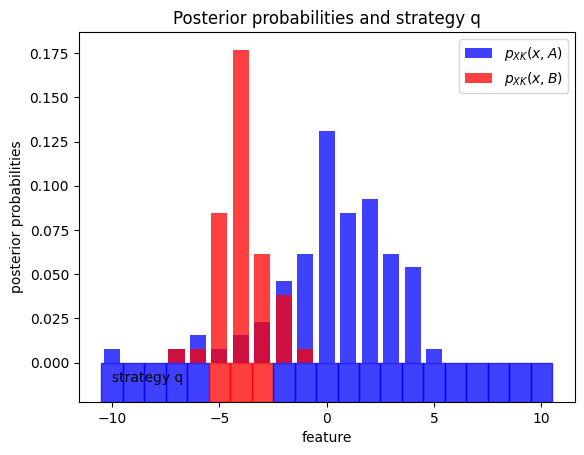

In [42]:
W1 = np.array([[0, 1],
              [1, 0]])
W2 = np.array([[0, 5], 
               [1, 0]])

q_discrete4 = find_strategy_discrete(discreteA, discreteC, W1)

visualize_discrete(discreteA, discreteC, q_discrete4)
plt.savefig("classif_W1.png")

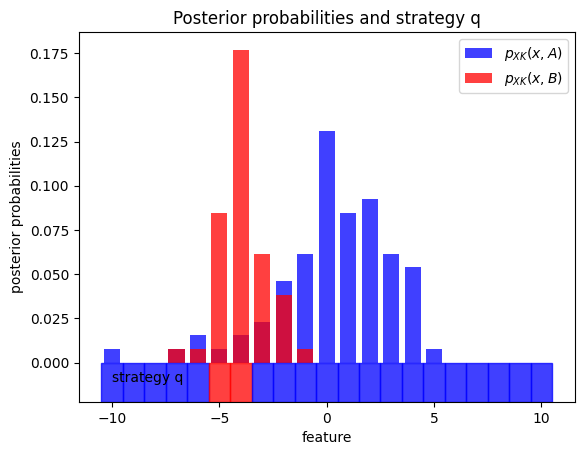

In [43]:
q_discrete5 = find_strategy_discrete(discreteA, discreteC, W2)

visualize_discrete(discreteA, discreteC, q_discrete5)
plt.savefig("classif_W2.png")

### Classification

Complete the `classify_discrete` function template which uses the found strategy for classification, so that it returns the labels given an array of image measurements. Also complete the `classification_error` function. The classification error is defined as the number of incorrectly classified samples divided by the total number of samples. To measure the error, compare your classification with the ground truth (=labels) in `labels_test` variable.

In [44]:
W = np.array([[0, 1], [1, 0]])
q_discrete_optimal = find_strategy_discrete(discreteA, discreteC, W)
measurements_discrete = compute_measurement_lr_discrete(images_test)
labels_estimated_discrete = classify_discrete(measurements_discrete, q_discrete_optimal)
error_discrete = classification_error(labels_estimated_discrete, labels_test)

# check if the result is correct
testing.assert_equal(error_discrete, 0.225, 'The error_discrete value is incorrect.')

### Classification results visualization

Show the images classified as A and images classified as C in a figure. Save it as `decision_discrete.png`.

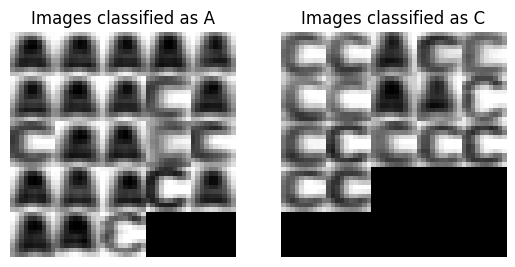

In [45]:
I_A = images_test[:,:,labels_estimated_discrete == 0]
I_C = images_test[:,:,labels_estimated_discrete == 1]

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(montage(I_A), cmap='gray')
plt.title('Images classified as A')
plt.subplot(1, 2, 2)
plt.imshow(montage(I_C), cmap='gray')
plt.title('Images classified as C')
plt.savefig("decision_discrete.png")

**Optional:** Use the interactive graph below to see how the optimal decision strategy changes with respect to changing loss function and the prior probabilities

In [46]:
# Use the following piece of code for interactive matplotlib
# It should work in VSCode, PyCharm and JupyterLab. Please, let us know if you encounter any difficulties.

# use this one in VSCode
%matplotlib inline
# and this one in PyCharm
# %matplotlib notebook

try:
    from ipywidgets import interact, interactive, fixed

    @interact(priorA=(0.,1.,0.01), w01=(0.1,10,0.01), w10=(0.1,10,0.01))
    def plot_bayes_cont_interactive(priorA=discreteA['Prior'], w01=W1[0,1], w10=W1[1,0]):
        W = np.array([[0, w01], [w10, 0]])
        discreteA_inter = {'Prob': discreteA['Prob'], 'Prior': priorA}
        discreteB_inter = {'Prob': discreteC['Prob'], 'Prior': 1 - priorA}
        q_discrete_inter = find_strategy_discrete(discreteA_inter, discreteB_inter, W)
        visualize_discrete(discreteA_inter, discreteB_inter, q_discrete_inter)

except ImportError:
    print('Optional feature.')

interactive(children=(FloatSlider(value=0.6153846153846154, description='priorA', max=1.0, step=0.01), FloatSl…

## Part 2: Continuous  measurements

In the second part of the assignment the probabilities $p_{X|k}(x|k)$ are given as continuous [Normal distributions](https://en.wikipedia.org/wiki/Normal_distribution): $$p_{X|k}(x|A) = \frac{1}{\sigma_k\sqrt{2\pi}}e^{-\frac{(x-\mu_k)^2}{2\sigma_k^2}}$$ Further we assume zero-one loss matrix: `W = np.array([[0, 1], [1, 0]])`.

In this particular case, as explained in [lecture slides](https://cw.fel.cvut.cz/wiki/_media/courses/be5b33rpz/lectures/pr_01_intro_and_bayes_2021.pdf), the optimal strategy $q$ can be found by solving the following problem:

$$q(x) = \arg\max_k p_{K|X}(k|x) = \arg\max_k p_{XK}(x,k)/p_X(x) = \arg\max_k p_{XK}(x,k) = \arg\max_k p_K(k)p_{X|K}(x|k),$$

where $p_{K|X}(k|x)$ is called *posterior* probability of class $k$ given the measurement $x$ (i.e. it is the probability of the data being from class $k$ if we measure feature value $x$). Symbol $\arg\max_k$ denotes finding $k$ maximising the argument.

This time we will work with unnormalised real-valued measurements instead of the discrete one used in Part 1:
```
x = ((sum of pixel values in the left half of image)
   -(sum of pixel values in the right half of image))
```
Computation of this measurement is implemented in `compute_measurement_lr_cont` function.

### The distributions

The distributions are defined as

In [47]:
contA = {'Mean': 124.2625,
         'Sigma': 1434.45420083,
         'Prior': 0.61538462}
contC = {'Mean': -2010.98,
         'Sigma': 558.42857106,
         'Prior': 0.38461538}

where the meaning of the variables is as follows.

| variable  | description                                                                    |
|-----------|--------------------------------------------------------------------------------|
| `contA['Mean']` | mean value of the normal distribution $p_{X\vert k}(x\vert A)$ |
| `contA['Sigma']` | standard deviation of the normal distribution $p_{X\vert k}(x\vert A)$ |
| `contA['Prior']` | prior probability $p_K(A)$ |
| `contC['Mean']` | mean value of the normal distribution $p_{X\vert k}(x\vert C)$ |
| `contC['Sigma']` | standard deviation of the normal distribution $p_{X\vert k}(x\vert C)$ |
| `contC['Prior']` | prior probability $p_K(C)$ |


### Quadratic discriminative function

During the class we will together show that in the case of $p_{X|k}(x|k)$ being Normal distributions and when we consider zero-one loss function, the optimal Bayesian strategy $q(x)$ corresponds to a quadratic inequality: $ax^2+bx+c \ge 0$, where the coefficients $a$, $b$ and $c$ depend on the parameters of the Normal distributions and the prior probabilities.

**Hint:**
$$
\arg\max_{k\in\{A,C\}} p_K(k)p_{X|k}(x|k) \quad \text{translates into} \quad p_K(A)p_{X|k}(x|A) \ge p_K(C)p_{X|k}(x|C)
$$

Solving the above quadratic inequality gives up to two thresholds $t_1$ and $t_2$ (zero crossing points) and a classification decision (A or C) in each of the intervals $\mathcal{X}_1 = (-\infty, t_1\rangle$, $\mathcal{X}_2 = (t_1, t_2\rangle$, $\mathcal{X}_3 = (t_2, \infty)$. So similarly to the discrete case we can **represent the strategy** in Python as a dict with the following fields:

|  field    |  description  |
|-----------|---------------|
| `q['t1']` | $t_1$ threshold (possibly $-\infty$) |
| `q['t2']` | $t_2$ threshold (possibly $\infty$) |
| `q['decision']` | (3, ) np.array containing the optimal decisions for each of the three intervals |




### The optimal strategy

Using the formulas for the coefficients of the quadratic inequality $a$, $b$ and $c$, complete the function `find_strategy_2normal`.

**Make sure that you return proper strategy for all corner cases**:
  - do not forget to consider same variances but different means, 
  - prior = 1 for one class, 
  - same mean and one prior significantly higher, 
  - both distributions the same but maybe prior is different, 
  - high prior + high variance, 
  - $p(x|A)p(A) = p(x|C)p(C)$ in exactly one point.

**All of these conditions can be tested by observing the quadratic inequality only, no pdf evaluation is needed!**

In [48]:
q_cont = find_strategy_2normal(contA, contC)
print(q_cont)

# check if the results are correct
testing.assert_almost_equal(q_cont['t1'], -3535.997150276402)
testing.assert_almost_equal(q_cont['t2'], -1248.7684903033442)
testing.assert_array_equal(q_cont['decision'], [0, 1, 0])

{'decision': array([0, 1, 0], dtype=int32), 't1': -3535.9971502764015, 't2': -1248.7684903033442}


### Strategy visualization

Using the `visualize_2norm` function in the template to display the probabilities $p_{Xk}(x,k)$ and the classification thresholds $t_1$ and $t_2$ and save the figure as `thresholds.png`.

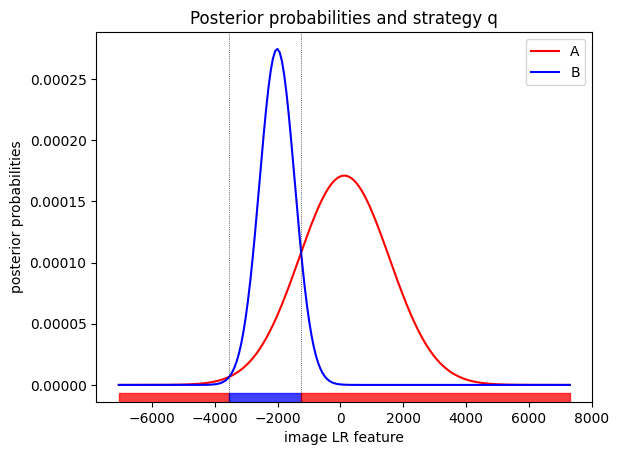

In [49]:
visualize_2norm(contA, contC, q_cont)
plt.savefig("thresholds.png")

### Bayes risk

Complete the template function `bayes_risk_2normal`. We can reformulate the equations from lecture slides, slide 21 as
\begin{align*}
R(q) &= \int_X \sum_{k\in K}p_{XK}(x,k)W(k,q(x)) dx = \\
&= \int_X p_X(x) \sum_{k\ne q(x)}p_{K|x}(k|x) dx = \\
&= \int_X p_X(x)(1 - p_{K|x}(q(x)|x)) dx = \\
&= 1 - \int_X p_X(x)p_{K|x}(q(x)|x) dx = \\
&= 1 - \int_X p_K(q(x))p_{X|k}(x|q(x)) dx\,,
\end{align*}
which in our special case simplifies further to $$R(q) = 1-\int_X p_K(q(x))p_{X|k}(x|q(x)) = \\ = 1 - \left( \int_{\mathcal{X}_1} p_K(\text{q.decision}(1))p_{X|k}(x|\text{q.decision}(1)) + \int_{\mathcal{X}_2} p_K(\text{q.decision}(2))p_{X|k}(x|\text{q.decision}(2)) + \\ \int_{\mathcal{X}_3} p_K(\text{q.decision}(3))p_{X|k}(x|\text{q.decision}(3))\right).$$ Thus we only need to compute integrals of the Normal distribution corresponding to the strategy decision class over three intervals, multiply them by apriori probabilities and subtract their sum from one.

**Hint:** To integrate exponential functions you can use the `scipy.stats.norm.cdf` function.


In [50]:
R_cont = bayes_risk_2normal(contA, contC, q_cont)

# check if the results are correct
testing.assert_almost_equal(R_cont, 0.13519281686757106 )

### Classification

Complete the `classify_2normal` function template so that it returns a label given a 10x10 image and the function `classification_error` to measures the classification error.

In [51]:
measurements_cont = compute_measurement_lr_cont(images_test)
labels_estimated_cont = classify_2normal(measurements_cont, q_cont)
error_cont = classification_error(labels_estimated_cont, labels_test)

# check if the results are correct
testing.assert_equal(error_cont, 0.1)

### Classification results visualization

Show the images classified as A and images classified as C using the `montage` function and save them as `decision_2normal.png`.

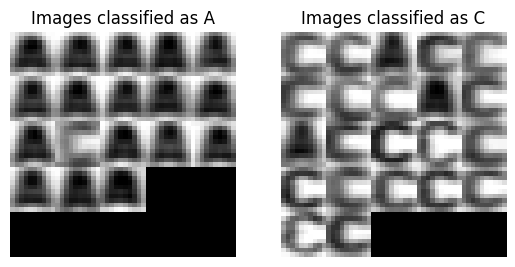

In [52]:
I_A_cont = images_test[:,:,labels_estimated_cont == 0]
I_C_cont = images_test[:,:,labels_estimated_cont == 1]

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(montage(I_A_cont), cmap='gray')
plt.title('Images classified as A')

plt.subplot(1, 2, 2)
plt.imshow(montage(I_C_cont), cmap='gray')
plt.title('Images classified as C')

plt.savefig("decision_2normal.png")

**Optional:** Use the interactive graph below to see how the optimal decision strategy changes with respect to the changing Normal distribution parameters and the prior probabilities

In [ ]:
# Use the following piece of code for interactive matplotlib
# It should work in PyCharm and JupyterLab. Please, let us know if you make it to work in VSCode.

# use this one in VSCode
%matplotlib inline
# and this one in PyCharm
# %matplotlib notebook

try:
    from ipywidgets import interact, interactive, fixed

    @interact(meanA=(-2500.,2500.,10.), sigmaA=(0.,2000.,10.), priorA=(0.,1.,0.01), meanB=(-2500.,2500.,10.), sigmaB=(0.,2000.,10.))
    def plot_bayes_cont_interactive(meanA=contA['Mean'], sigmaA=contA['Sigma'], priorA=contA['Prior'], meanB=contC['Mean'], sigmaB=contC['Sigma']):
        plt.figure()
        cont_A_inter = {'Mean': meanA, 'Sigma': sigmaA, 'Prior': priorA}
        cont_B_inter = {'Mean': meanB, 'Sigma': sigmaB, 'Prior': 1 - cont_A_inter['Prior']}
        q_cont_inter = find_strategy_2normal(cont_A_inter, cont_B_inter)
        visualize_2norm(cont_A_inter, cont_B_inter, q_cont_inter)

except ImportError:
    print('Optional feature.')

interactive(children=(FloatSlider(value=124.2625, description='meanA', max=2500.0, min=-2500.0, step=10.0), Fl…

## Submission to the BRUTE Upload System

To fulfill this assignment, you need to submit these files (all packed in one `.zip` file) into the __[upload system](https://cw.felk.cvut.cz/brute/)__:

- `bayes.ipynb` - a notebook for data initialisation, calling of the implemented functions and plotting of their results (for your convenience, will not be checked).
- `bayes.py` - file with the following methods implemented:
    - `find_strategy_discrete` - function which finds the optimal discrete strategy
    - `bayes_risk_discrete` - function which computes the Bayesian risk for a given discrete strategy
    - `classify_discrete` - function which classifies a given data sample using a discrete strategy
    - `classification_error` - function which computes classification error given predictions and ground truth labels
    - `find_strategy_2normal` - function which finds the optimal continuous strategy
    - `bayes_risk_2normal` - function which computes the Bayesian risk for a given continuous strategy
    - `classify_2normal` - function which classifies a given data sample using a continuous strategy
- `classif_W1.png`, `classif_W2.png` and `decision_discrete.png` - images specified in Discrete measurements section
- `thresholds.png`, `decision_2normal.png` - images specified in Continuous measurements section

When preparing a zip file for the upload system, **do not include any directories**, the files have to be in the zip file root.

## Bonus task

**This task is not compulsory.** Work on bonus tasks deepens your knowledge about the subject. Successful solution of a bonus task will be rewarded by up to 4 points.

When working on this task, you better start a new Jupyter notebook.

The data for this task is located in `data_33rpz_bayes_bonus.npz`. Use the following distributions `D1`, `D2` and `D3`:

In [54]:
D1 = {'Mean': np.array([151.61, 1154.01]),
      'Prior': 0.4166666666666667,
      'Cov': np.array([[2048960.78575758, 169829.10494949],
                       [ 169829.10494949, 482516.97969697]])}

D2 = {'Mean': np.array([-2055.76666667,    54.3]),
      'Prior': 0.25,
      'Cov': np.array([[307539.97853107,  -2813.69830508],
                       [ -2813.69830508, 485574.58644068]])}

D3 = {'Mean': np.array([  492.7125, -2353.1125]),
      'Prior': 0.3333333333333333,
      'Cov': np.array([[968935.42262658,  12248.03053797],
                       [ 12248.03053797, 407017.16439873]])}

The task is analogous to the previous one, but there are now *two* measurements (features) and *three* classes. The second measurement is

```
y = (sum of pixel values in the upper half of image)
   -(sum of pixel values in the lower half of image)
```
The alphabet (i.e. the classes) now consists of three letters: A, C, and T.

The task is to classify the input images into one of the three classes. Use both measurements $x$ and $y$ here.
The density function $p_{X}(\mathbf{x}) = p_K(A)p_{X|k}(\mathbf{x}|A)+p_K(C)p_{X|k}(\mathbf{x}|C)+p_K(T)p_{X|k}(\mathbf{x}|T)$ is fully defined by the above distribution variables `D1`, `D2` and `D3`.

**Expected output:**

  * Classification error of the optimal Bayesian strategy on the provided image set,
  * Visualization of the classification of input images, i.e. which image was assigned to which class – draw the images per class.

**Hints:**
  * [Multivariate Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) distribution density is given by $$f_{\mathbf x}(x_1,\ldots,x_k) = \frac{1}{\sqrt{(2\pi)^k|\boldsymbol\Sigma|}}\exp\left(-\frac{1}{2}({\mathbf x}-{\boldsymbol\mu})^T{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})\right),$$ where $k$ is number of dimensions, $\boldsymbol\Sigma$ is $k \times k$ covariance matrix and $\boldsymbol\mu$ is $k$-dimensional mean vector.

  * Calculate numerically the Bayesian risk for all decisions for every input image and select the optimal decision.

## References

[1] Duda R., Hart P., Stock D.: Pattern Classification, 2001
[2] Michail I. Schlesinger, Vaclav Hlavac. Ten Lectures on Statistical and Structural Pattern Recognition. Kluwer Academic Publishers, 2002.